[IPython notebook for PyData SF 2014 tutorial: "Gradient Boosted Regression Trees in scikit-learn"](https://github.com/pprett/pydata-gbrt-tutorial)

In [1]:
import warnings
warnings.filterwarnings("ignore")

# Gradient Boosted Regression Trees

<img src="files/sklearn-logo.png" />

## Scikit-learn

 * Easy-to-use Machine Learning toolkit
 * Classical, well-established machine learning algorithms
 * BSD 3 license

### Estimator

"*An estimator is any object that learns from data; it may be a classification, regression or clustering algorithm or a transformer that extracts/filters useful features from raw data.*"

In [2]:
class Estimator(object):
  
    def fit(self, X, y=None):
        """Fits estimator to data. """
        # set state of ``self``
        return self
            
    def predict(self, X):
        """Predict response of ``X``. """
        # compute predictions ``pred``
        return pred

Scikit-learn provides two estimators for gradient boosting: ``GradientBoostingClassifier`` and ``GradientBoostingRegressor``, both are located in the ``sklearn.ensemble`` package:

In [3]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor

Estimators support arguments to control the fitting behaviour -- these arguments are often called _hyperparameters_. Among the most important ones for GBRT are:

  * number of regression trees (``n_estimators``)
  * depth of each individual tree (``max_depth``)
  * loss function (``loss``)

For example if you want to fit a regression model with 100 trees of depth 3 using least-squares:

In [4]:
est = GradientBoostingRegressor(n_estimators=100, max_depth=3, loss='ls')

In [5]:
est?

Here is an self-contained example that shows how to fit a ``GradientBoostingClassifier`` to a synthetic dataset:

In [6]:
from sklearn.datasets import make_hastie_10_2
from sklearn.model_selection import train_test_split

# generate synthetic data from ESLII - Example 10.2
X, y = make_hastie_10_2(n_samples=5000)
X_train, X_test, y_train, y_test = train_test_split(X, y)

# fit estimator
est = GradientBoostingClassifier(n_estimators=200, max_depth=3)
est.fit(X_train, y_train)

# predict class labels
pred = est.predict(X_test)

# score on test data (accuracy)
acc = est.score(X_test, y_test)
print('ACC: %.4f' % acc)

# predict class probabilities
est.predict_proba(X_test)[0]

ACC: 0.9096


array([0.15165955, 0.84834045])

The state of the estimator is stored in instance attributes that have a trailing underscore ('\_'). For example, the sequence of regression trees (``DecisionTreeRegressor`` objects) is stored in ``est.estimators_``:

In [7]:
est.estimators_[0, 0]

DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
           max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort='auto',
           random_state=<mtrand.RandomState object at 0x7f0fd646f168>,
           splitter='best')

## Gradient Boosted Regression Trees in Practise

### Function approximation

  * Sinoide function + random gaussian noise 
  * 80 training (blue), 20 test (red) points

Populating the interactive namespace from numpy and matplotlib


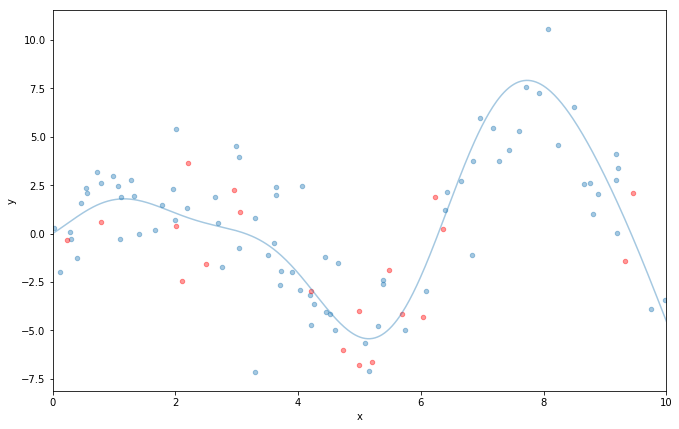

In [8]:
%pylab inline
import numpy as np
from sklearn.model_selection import train_test_split

FIGSIZE = (11, 7)

def ground_truth(x):
    """Ground truth -- function to approximate"""
    return x * np.sin(x) + np.sin(2 * x)

def gen_data(n_samples=200):
    """generate training and testing data"""
    np.random.seed(15)
    X = np.random.uniform(0, 10, size=n_samples)[:, np.newaxis]
    y = ground_truth(X.ravel()) + np.random.normal(scale=2, size=n_samples)
    train_mask = np.random.randint(0, 2, size=n_samples).astype(np.bool)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = gen_data(100)

# plot ground truth
x_plot = np.linspace(0, 10, 500)

def plot_data(alpha=0.4, s=20):
    fig = plt.figure(figsize=FIGSIZE)
    gt = plt.plot(x_plot, ground_truth(x_plot), alpha=alpha, label='ground truth')

    # plot training and testing data
    plt.scatter(X_train, y_train, s=s, alpha=alpha)
    plt.scatter(X_test, y_test, s=s, alpha=alpha, color='red')
    plt.xlim((0, 10))
    plt.ylabel('y')
    plt.xlabel('x')
    
annotation_kw = {'xycoords': 'data', 'textcoords': 'data',
                 'arrowprops': {'arrowstyle': '->', 'connectionstyle': 'arc'}}
    
plot_data()

### Regression Trees

  * ``max_depth`` argument controlls the depth of the tree
  * The deeper the tree the more variance can be explained

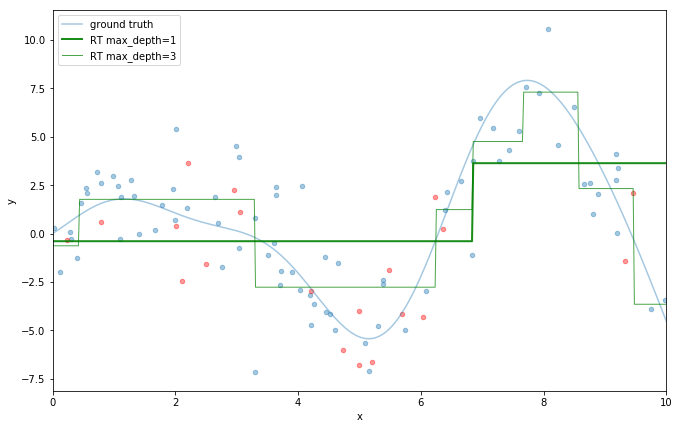

In [9]:
from sklearn.tree import DecisionTreeRegressor
plot_data()
est = DecisionTreeRegressor(max_depth=1).fit(X_train, y_train)
plt.plot(x_plot, est.predict(x_plot[:, np.newaxis]),
         label='RT max_depth=1', color='g', alpha=0.9, linewidth=2)

est = DecisionTreeRegressor(max_depth=3).fit(X_train, y_train)
plt.plot(x_plot, est.predict(x_plot[:, np.newaxis]),
         label='RT max_depth=3', color='g', alpha=0.7, linewidth=1)

plt.legend(loc='upper left')

### Function approximation with Gradient Boosting

  * ``n_estimators`` argument controls the number of trees
  * ``staged_predict`` method allows us to step through predictions as we add more trees

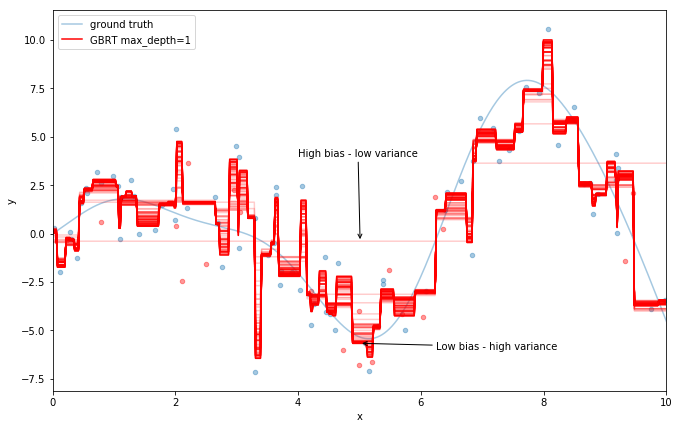

In [10]:
from itertools import islice

plot_data()
est = GradientBoostingRegressor(n_estimators=1000, max_depth=1, learning_rate=1.0)
est.fit(X_train, y_train)

ax = plt.gca()
first = True

# step through prediction as we add 10 more trees.
for pred in islice(est.staged_predict(x_plot[:, np.newaxis]), 0, est.n_estimators, 10):
    plt.plot(x_plot, pred, color='r', alpha=0.2)
    if first:
        ax.annotate('High bias - low variance', xy=(x_plot[x_plot.shape[0] // 2],
                                                    pred[x_plot.shape[0] // 2]),
                                                    xytext=(4, 4), **annotation_kw)
        first = False

pred = est.predict(x_plot[:, np.newaxis])
plt.plot(x_plot, pred, color='r', label='GBRT max_depth=1')
ax.annotate('Low bias - high variance', xy=(x_plot[x_plot.shape[0] // 2],
                                            pred[x_plot.shape[0] // 2]),
                                            xytext=(6.25, -6), **annotation_kw)
plt.legend(loc='upper left')

### Model complexity

  * The number of trees and the depth of the individual trees control model complexity
  * Model complexity comes at a price: **overfitting**
  
  
### Deviance plot

  * Diagnostic to determine if model is overfitting
  * Plots the training/testing error (deviance) as a function of the number of trees (=model complexity)
  * Training error (deviance) is stored in ``est.train_score_``
  * Test error is computed using ``est.staged_predict``

Text(810,3.5,'train-test gap')

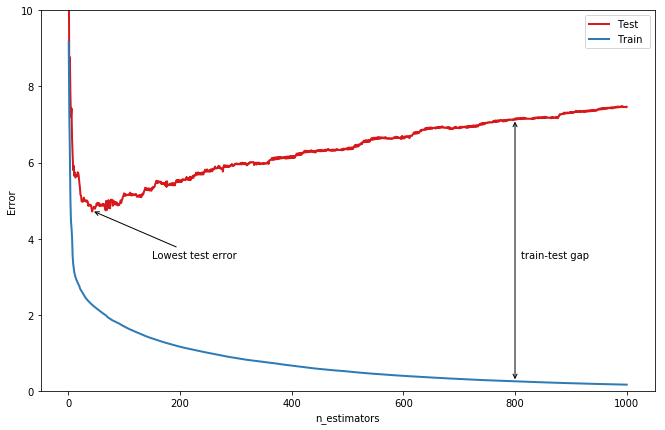

In [11]:
def deviance_plot(est, X_test, y_test, ax=None, label='', train_color='#2c7bb6', 
                  test_color='#d7191c', alpha=1.0, ylim=(0, 10)):
    """Deviance plot for ``est``, use ``X_test`` and ``y_test`` for test error. """
    n_estimators = len(est.estimators_)
    test_dev = np.empty(n_estimators)

    for i, pred in enumerate(est.staged_predict(X_test)):
        test_dev[i] = est.loss_(y_test, pred)

    if ax is None:
        fig = plt.figure(figsize=FIGSIZE)
        ax = plt.gca()
        
    ax.plot(np.arange(n_estimators) + 1, test_dev, color=test_color, label='Test %s' % label, 
             linewidth=2, alpha=alpha)
    ax.plot(np.arange(n_estimators) + 1, est.train_score_, color=train_color, 
             label='Train %s' % label, linewidth=2, alpha=alpha)
    ax.set_ylabel('Error')
    ax.set_xlabel('n_estimators')
    ax.set_ylim(ylim)
    return test_dev, ax

test_dev, ax = deviance_plot(est, X_test, y_test)
ax.legend(loc='upper right')

# add some annotations
ax.annotate('Lowest test error', xy=(test_dev.argmin() + 1, test_dev.min() + 0.02),
            xytext=(150, 3.5), **annotation_kw)

ann = ax.annotate('', xy=(800, test_dev[799]),  xycoords='data',
                  xytext=(800, est.train_score_[799]), textcoords='data',
                  arrowprops={'arrowstyle': '<->'})
ax.text(810, 3.5, 'train-test gap')

### Overfitting

  * Model has too much capacity and starts fitting the idiosyncracies of the training data
  * Indicated by a large gap between train and test error
  * GBRT provides a number of knobs to control overfitting

## Regularization

  * Tree structure
  * Shrinkage
  * Stochastic Gradient Boosting

## Tree Structure

  * The ``max_depth`` of the trees controls the degree of features interactions (variance++)
  * Use ``min_samples_leaf`` to have a sufficient number of samples per leaf (bias++)

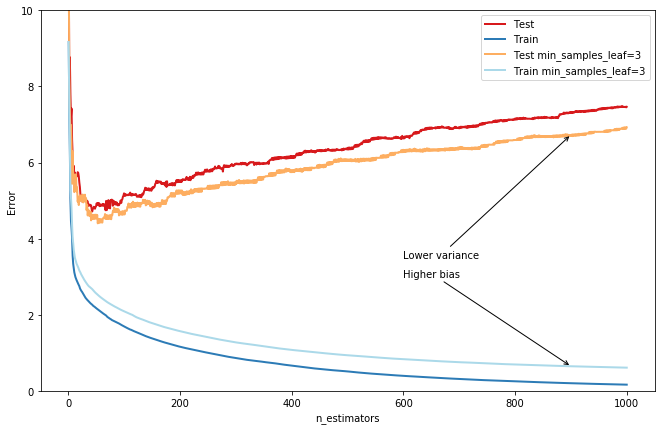

In [12]:
def fmt_params(params):
    return ", ".join("{0}={1}".format(key, val) for key, val in params.items())

fig = plt.figure(figsize=FIGSIZE)
ax = plt.gca()
for params, (test_color, train_color) in [({}, ('#d7191c', '#2c7bb6')),
                                          ({'min_samples_leaf': 3}, ('#fdae61', '#abd9e9'))]:
    est = GradientBoostingRegressor(n_estimators=1000, max_depth=1, 
                                    learning_rate=1.0)
    est.set_params(**params)
    est.fit(X_train, y_train)
    test_dev, ax = deviance_plot(est, X_test, y_test, ax=ax, label=fmt_params(params),
                                 train_color=train_color, test_color=test_color)
    
ax.annotate('Higher bias', xy=(900, est.train_score_[899]), xytext=(600, 3), **annotation_kw)
ax.annotate('Lower variance', xy=(900, test_dev[899]), xytext=(600, 3.5), **annotation_kw)
plt.legend(loc='upper right')

## Shrinkage

 * Slow learning by shrinking the predictions of each tree by some small scalar (``learning_rate``)
 * A lower ``learning_rate`` requires a higher number of ``n_estimators``
 * Its a trade-off between runtime against accuracy.

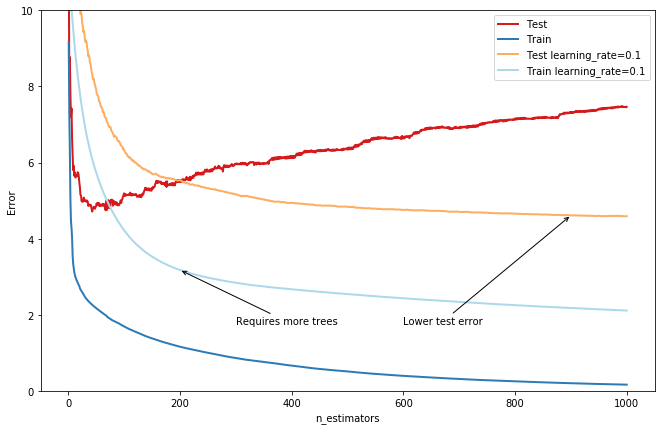

In [13]:
fig = plt.figure(figsize=FIGSIZE)
ax = plt.gca()
for params, (test_color, train_color) in [({}, ('#d7191c', '#2c7bb6')),
                                          ({'learning_rate': 0.1},
                                           ('#fdae61', '#abd9e9'))]:
    est = GradientBoostingRegressor(n_estimators=1000, max_depth=1, learning_rate=1.0)
    est.set_params(**params)
    est.fit(X_train, y_train)
    
    test_dev, ax = deviance_plot(est, X_test, y_test, ax=ax, label=fmt_params(params),
                                 train_color=train_color, test_color=test_color)
    
ax.annotate('Requires more trees', xy=(200, est.train_score_[199]), 
            xytext=(300, 1.75), **annotation_kw)
ax.annotate('Lower test error', xy=(900, test_dev[899]),
            xytext=(600, 1.75), **annotation_kw)
plt.legend(loc='upper right')

## Stochastic Gradient Boosting

 * Subsampling the training set before growing each tree (``subsample``)
 * Subsampling the features before finding the best split node (``max_features``)
 * Latter usually works better if there is a sufficient large number of features

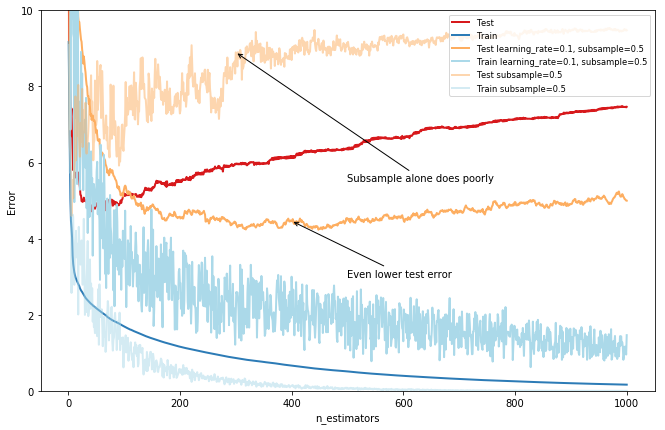

In [14]:
fig = plt.figure(figsize=FIGSIZE)
ax = plt.gca()
for params, (test_color, train_color) in [({}, ('#d7191c', '#2c7bb6')),
                                          ({'learning_rate': 0.1, 'subsample': 0.5},
                                           ('#fdae61', '#abd9e9'))]:
    est = GradientBoostingRegressor(n_estimators=1000, max_depth=1, learning_rate=1.0,
                                    random_state=1)
    est.set_params(**params)
    est.fit(X_train, y_train)
    test_dev, ax = deviance_plot(est, X_test, y_test, ax=ax, label=fmt_params(params),
                                 train_color=train_color, test_color=test_color)
    
ax.annotate('Even lower test error', xy=(400, test_dev[399]),
            xytext=(500, 3.0), **annotation_kw)

est = GradientBoostingRegressor(n_estimators=1000, max_depth=1, learning_rate=1.0,
                                subsample=0.5)
est.fit(X_train, y_train)
test_dev, ax = deviance_plot(est, X_test, y_test, ax=ax, label=fmt_params({'subsample': 0.5}),
                             train_color='#abd9e9', test_color='#fdae61', alpha=0.5)
ax.annotate('Subsample alone does poorly', xy=(300, test_dev[299]), 
            xytext=(500, 5.5), **annotation_kw)
plt.legend(loc='upper right', fontsize='small')

## Hyperparameter tuning

I usually follow this recipe to tune the hyperparameters:

  1. Pick ``n_estimators`` as large as (computationally) possible (e.g. 3000)
  2. Tune ``max_depth``, ``learning_rate``, ``min_samples_leaf``, and ``max_features`` via grid search
  3. Increase ``n_estimators`` even more and tune ``learning_rate`` again holding the other parameters fixed

In [15]:
from sklearn import metrics
sorted(metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'brier_score_loss',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'mutual_info_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'v_measure_score']

In [16]:
from sklearn.model_selection import GridSearchCV

param_grid = {'learning_rate': [0.1, 0.01, 0.001],
              'max_depth': [4, 6],
              'min_samples_leaf': [3, 5]  ## depends on the nr of training examples
              # 'max_features': [1.0, 0.3, 0.1] ## not possible in our example (only 1 fx)
              }

est = GradientBoostingRegressor(n_estimators=3000)
# this may take some minutes
gs_cv = GridSearchCV(est, param_grid, scoring='neg_mean_squared_error', n_jobs=4, cv=3).fit(X_train, y_train)

# best hyperparameter setting
print('Best hyperparameters: %r' % gs_cv.best_params_)

/home/software/miniconda3/envs/tnn/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best hyperparameters: {'learning_rate': 0.001, 'max_depth': 6, 'min_samples_leaf': 5}


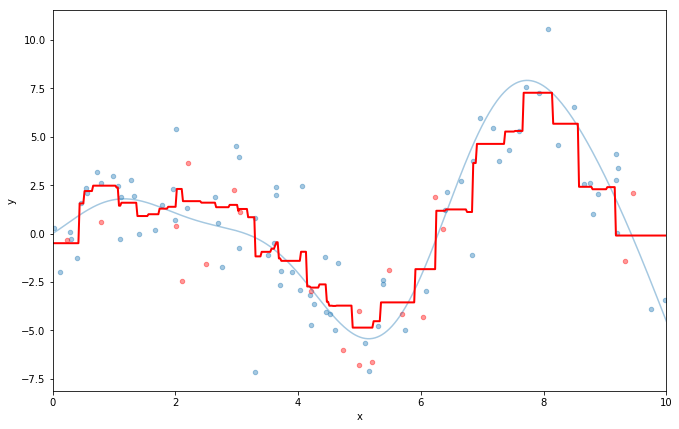

In [17]:
# refit model on best parameters
est.set_params(**gs_cv.best_params_)
est.fit(X_train, y_train)

# plot the approximation
plot_data()
plt.plot(x_plot, est.predict(x_plot[:, np.newaxis]), color='r', linewidth=2)

Caution: Hyperparameters interact with each other (``learning_rate`` and ``n_estimators``, ``learning_rate`` and ``subsample``, ``max_depth`` and ``max_features``).

See [G. Ridgeway, "Generalized boosted models: A guide to the gbm package", 2005](http://citeseerx.ist.psu.edu/viewdoc/download;jsessionid=540A0A638283F64E251B1342248CDBCF?doi=10.1.1.151.4024&rep=rep1&type=pdf)

# Use-case: California Housing

<img src="files/cal-housing.png" /><br />

 * Predict the median house value for census block groups in California
 * 20.000 groups, 8 features: *median income*, *average house age*, *latitude*, *longitude*, ...
 * Mean Absolute Error on 80-20 train-test split

In [18]:
from sklearn.datasets.california_housing import fetch_california_housing

cal_housing = fetch_california_housing()

# split 80/20 train-test
X_train, X_test, y_train, y_test = train_test_split(cal_housing.data,
                                                    cal_housing.target,
                                                    test_size=0.2,
                                                    random_state=1)
names = cal_housing.feature_names

## Challenges

  * heterogenous features (different scales and distributions, see plot below)
  * non-linear feature interactions (interaction: latitude and longitude)
  * extreme responses (robust regression techniques)


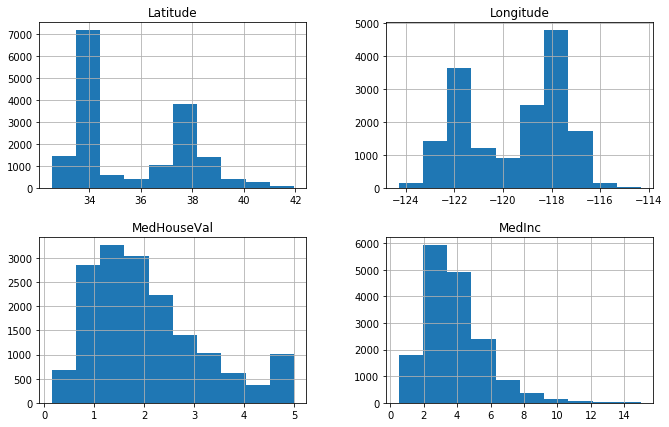

In [19]:
import pandas as pd
X_df = pd.DataFrame(data=X_train, columns=names)
X_df['MedHouseVal'] = y_train
_ = X_df.hist(column=['Latitude', 'Longitude', 'MedInc', 'MedHouseVal'], figsize=FIGSIZE)

## Evaluation

  * GBRT vs RandomForest vs SVM vs Ridge Regression

In [20]:
import time
from collections import defaultdict
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor
from sklearn.svm import SVR

res = defaultdict(dict)

def benchmark(est, name=None):
    if not name:
        name = est.__class__.__name__
    t0 = time.clock()
    est.fit(X_train, y_train)
    res[name]['train_time'] = time.clock() - t0
    t0 = time.clock()
    pred = est.predict(X_test)
    res[name]['test_time'] = time.clock() - t0
    res[name]['MAE'] = mean_absolute_error(y_test, pred)
    return est
    
benchmark(DummyRegressor())
benchmark(Ridge(alpha=0.0001, normalize=True))
benchmark(Pipeline([('std', StandardScaler()), 
                    ('svr', SVR(kernel='rbf', C=10.0, gamma=0.1, tol=0.001))]), name='SVR')
benchmark(RandomForestRegressor(n_estimators=100, max_features=5, random_state=0, 
                                bootstrap=False, n_jobs=4))
est = benchmark(GradientBoostingRegressor(n_estimators=500, max_depth=4, learning_rate=0.1,
                                          loss='huber', min_samples_leaf=3, 
                                          random_state=0))

res_df = pd.DataFrame(data=res).T
res_df[['train_time', 'test_time', 'MAE']].sort_values('MAE', ascending=False)

,train_time,test_time,MAE
DummyRegressor,0.000555,0.000082,0.909090
Ridge,0.057215,0.000658,0.532860
SVR,15.364185,1.097407,0.379575
RandomForestRegressor,7.032806,0.100479,0.318291
GradientBoostingRegressor,6.173702,0.024736,0.300736


### Exercise

The above ``GradientBoostingRegressor`` is not properly tuned for this dataset. Diagnose the current model and find more appropriate hyperparameter settings. 

Hint: check whether you are in the high-bias or high-variance regime

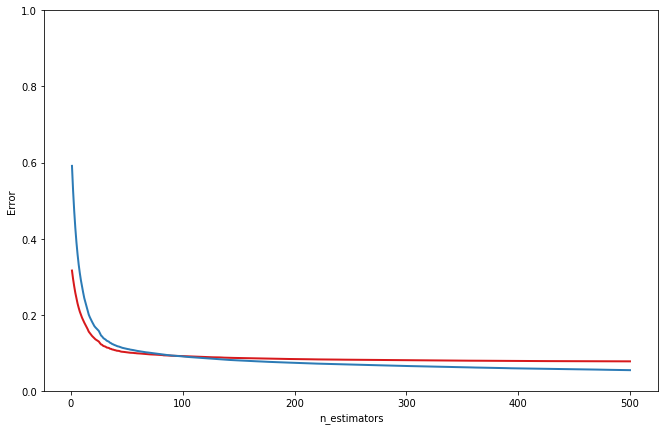

In [21]:
# diagnose the model
test_dev, ax = deviance_plot(est, X_test, y_test, ylim=(0, 1.0))

In [22]:
## modify the hyperparameters
#tuned_est = benchmark(GradientBoostingRegressor(n_estimators=500, max_depth=4, learning_rate=0.1,
#                                                loss='huber', random_state=0, verbose=1))

## print results
#res_df = pd.DataFrame(data=res).T
#res_df[['train_time', 'test_time', 'MAE']].sort('MAE', ascending=False)

## Feature importance

  * What are the important features and how do they contribute in predicting the target response?
  * Derived from the regression trees 
  * Can be accessed via the attribute ``est.feature_importances_``

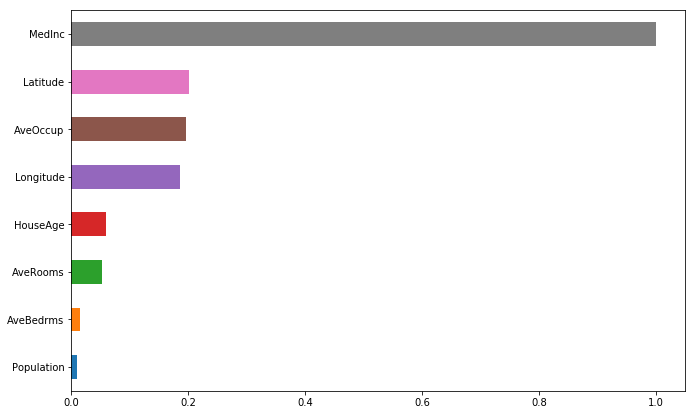

In [23]:
fx_imp = pd.Series(est.feature_importances_, index=names)
fx_imp /= fx_imp.max()  # normalize
fx_imp.sort_values(inplace=True)
fx_imp.plot(kind='barh', figsize=FIGSIZE)

## Partial dependence

  * Relationship between the response and a set of features, marginalizing over all other features
  * Intuitively: expected response as a function of the features we conditioned on

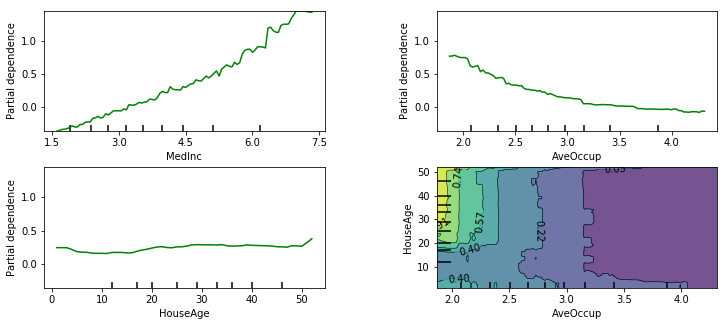

In [24]:
from sklearn.ensemble.partial_dependence import plot_partial_dependence

features = ['MedInc', 'AveOccup', 'HouseAge',
            ('AveOccup', 'HouseAge')]
fig, axs = plot_partial_dependence(est, X_train, features, feature_names=names, 
                                   n_cols=2, figsize=FIGSIZE)

Scikit-learn provides a convenience function to create such plots and a low-level function that you can use to create custom partial dependence plots (e.g. map overlays or 3d plots). 
More detailed information can be found [here](http://scikit-learn.org/dev/modules/ensemble.html#partial-dependence).

<img src="files/pdp_lat_lon_cal.png" style="width: 50%;float: left"/>
<img src="files/pdp_lat_lon_sf.png" style="width: 50%;"/>

## Performance

Comparision of scikit-learn against R's [gbm](http://cran.r-project.org/web/packages/gbm/index.html) package.

<img src="files/benchmarks.png"/>


## Tipps & Tricks

### Categorical features

Scikit-learn requires that categorical variables are encoded as numerics. For tree-based methods ordinal encoding is as effective as one-hot encoding but more efficient (less memory & faster runtime) given that you grow deep enough trees:

In [25]:
df = pd.DataFrame(data={'icao': ['CRJ2', 'A380', 'B737', 'B737']})
# ordinal encoding
df_enc = pd.DataFrame(data={'icao': np.unique(df.icao,
                      return_inverse=True)[1]})
X = np.asfortranarray(df_enc.values, dtype=np.float32)

## Feature interactions

GBRT automatically detects feature interactions but often explicit interactions help.

Trees required to approximate $X_1 - X_2$: 10 (left), 1000 (right)

<img src="files/func_approx_minus_2.png" style="width: 50%;float: left"/>
<img src="files/func_approx_minus_3.png" style="width: 50%;"/>

## Summary

 - Flexible non-parametric classification and regression technique
 - Applicable to a variety of problems
 - Solid, battle-worn implementation in scikit-learn
 
<img src="http://www.kaggle.com/content/v/d6801c936e94/kaggle/img/site-logo.png" style="margin-left:2em;width:8em;"/>